In [19]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch

from mads_hackathon import datasets, metrics
import mltrainer
import tomllib

In [20]:
datadir = Path('../data/raw')
trainfile = (datadir / "heart_big_train.parq").resolve()
validfile = (datadir / "heart_big_valid.parq").resolve()
trainfile.exists(), validfile.exists()

(True, True)

Load the data

In [21]:
traindataset = datasets.HeartDataset1D(trainfile, target="target")
validdataset = datasets.HeartDataset1D(validfile, target="target")
traindataset, validdataset

# moving to mps device crashes the jypyter kernel, I wasnt able to fix that...

(Heartdataset (len 87554), Heartdataset (len 10946))

Visualise it as 1D data

torch.Size([192, 1]) tensor(0)


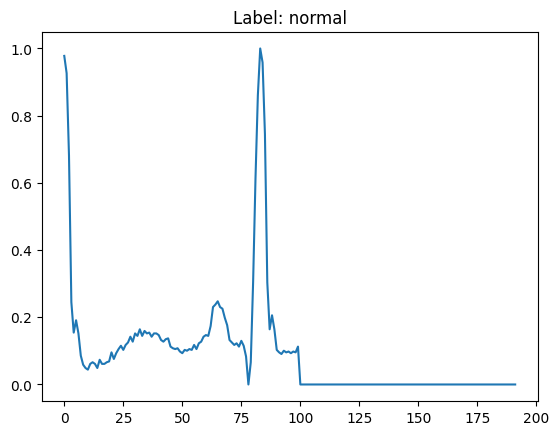

In [22]:
x, y = traindataset[0]
viz = x.squeeze().cpu().numpy()
sns.lineplot(x=range(len(viz)), y=viz)
title = 'normal' if y == 0 else 'abnormal'
plt.title(f"Label: {title}");
print(x.shape, y)

In [23]:
from mads_hackathon.models import TransformerConfig as Config

config = Config(
    batchsize=128,
    dropout=0.1,
    input_channels=1,
    hidden=64,
    kernel_size=3,
    stride=1,
    num_heads=2,
    num_blocks=2,
    num_classes=5,
)

Set up the streamer

In [24]:
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=config.batchsize)
validstreamer = BaseDatastreamer(validdataset, preprocessor = BasePreprocessor(), batchsize=config.batchsize)
len(trainstreamer), len(validstreamer)

(684, 85)

Note, the layers have different assumptions about the data structure:
- streamer:         (batch, seq_len, channels)
- conv1d:           (batch, channels, seq_len)
- pos_encoding:     (batch, seq_len, channels)
- gru (batchfirst): (batch, seq_len, channels)
- attention:        (batch, seq_len, channels)

As you can see, its just the conv1d layer that expects channels as the second dimension. Using a conv1d layer you
will need to transpose the dimensions, I will show how to do that in the Transformer `forward` method.

Again, the strategy of creating a block helps us stack the architecture more easily.

In [25]:
from mads_hackathon.models import Transformer
model = Transformer(config)

In [26]:
x, y = next(trainstreamer.stream())
x.shape, y.shape

(torch.Size([128, 192, 1]), torch.Size([128]))

In [27]:
from torchinfo import summary

summary(model, input_size=x.shape)

Layer (type:depth-idx)                   Output Shape              Param #
Transformer                              [128, 5]                  --
├─Conv1d: 1-1                            [128, 64, 192]            256
├─PositionalEncoding: 1-2                [128, 192, 64]            --
│    └─Dropout: 2-1                      [128, 192, 64]            --
├─ModuleList: 1-3                        --                        --
│    └─TransformerBlock: 2-2             [128, 192, 64]            --
│    │    └─MultiheadAttention: 3-1      [128, 192, 64]            16,640
│    │    └─LayerNorm: 3-2               [128, 192, 64]            128
│    │    └─Sequential: 3-3              [128, 192, 64]            8,320
│    │    └─LayerNorm: 3-4               [128, 192, 64]            128
│    └─TransformerBlock: 2-3             [128, 192, 64]            --
│    │    └─MultiheadAttention: 3-5      [128, 192, 64]            16,640
│    │    └─LayerNorm: 3-6               [128, 192, 64]            128


In [28]:
yhat = model(x)
yhat.shape

torch.Size([128, 5])

In [31]:
yhat

tensor([[-0.2479,  0.4577,  0.5151, -0.7025,  0.3520],
        [-0.2292,  0.4530,  0.5657, -0.7041,  0.3041],
        [-0.2422,  0.1564,  0.7366, -0.7395,  0.2851],
        [-0.2454,  0.2747,  0.6689, -0.7583,  0.2950],
        [-0.2427,  0.2610,  0.7020, -0.7451,  0.2807],
        [-0.2279,  0.2269,  0.6946, -0.7707,  0.3221],
        [-0.2404,  0.1244,  0.7344, -0.7393,  0.2942],
        [-0.2467,  0.2643,  0.6745, -0.7551,  0.3093],
        [-0.2546,  0.2300,  0.6819, -0.7555,  0.3066],
        [-0.2367,  0.1813,  0.7230, -0.7751,  0.2945],
        [-0.2345,  0.1665,  0.6989, -0.7627,  0.3239],
        [-0.2263,  0.2265,  0.7069, -0.7657,  0.3071],
        [-0.2294,  0.1856,  0.6946, -0.7496,  0.3195],
        [-0.2433,  0.1626,  0.7370, -0.7889,  0.2943],
        [-0.2499,  0.2782,  0.6383, -0.7274,  0.3241],
        [-0.2054,  0.1719,  0.7059, -0.7815,  0.3097],
        [-0.2321,  0.1688,  0.7202, -0.7809,  0.3058],
        [-0.2272,  0.1536,  0.7238, -0.7872,  0.3015],
        [-

In [29]:
from mads_hackathon.metrics import caluclate_cfm
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

In [30]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
from dataclasses import asdict
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=5,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart1D",
        train_steps=len(trainstreamer),
        valid_steps=len(validstreamer),
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    mlflow.set_tag("model", "Transfomer")
    mlflow.set_tag("dataset", "heart1D")
    mlflow.set_tag("dev", dev)
    mlflow.log_params(asdict(config))
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=validstreamer.stream(),
        scheduler=None,
        )
    trainer.loop()
    cfm = caluclate_cfm(model, teststreamer)
    for i, tp in enumerate(np.diag(cfm)):
        mlflow.log_metric(f"TP_{i}", tp)
plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

2024-11-25 10:37:20.378 | INFO     | mltrainer.settings:check_path:61 - Created logdir /Users/tijsvandervelden/Development/hackathon/hackathon/notebooks/logs/heart1D


NameError: name 'dev' is not defined

In [ ]:
plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")